# K-fold cross validation

**Author: [Kevin Broløs](https://abzu.ai/team)**

K-fold cross validation is all about splitting your (typically training set) into K equally sized folds, training on the majority and validating on the final fold.

In order to reduce the likelihood that you just got a "lucky" split, you then mix up which folds you train on and which you validate on, and calculate, typically, the average performance across folds.

This helps ensure your model generalises, regardless of how you split the data.


You can combine this method with the method of hyperparameter search, which we'll discuss later, to find the optimal parameters for your model.

In [1]:
from sklearn.datasets import load_iris
from IPython.display import display
from sklearn import model_selection
import numpy as np

import matplotlib.pyplot as plt

random_state = 42 # For convenience and reproducibility in results. Don't do this in production
np.random.seed(random_state)

In [2]:
iris=load_iris()
data, feature_names = iris.data, iris.feature_names
target, target_names = iris.target, iris.target_names

## Doing it "the manual" way, so you can follow along

In [3]:
def get_folds(X, y, n_splits=3):
    # Get a list of random permuted indices from 0-size (the same as shuffling the set)
    shuffled_indices = np.random.permutation(len(y))
    
    X_shuffled, y_shuffled = X[shuffled_indices], y[shuffled_indices]
    
    return np.array(np.split(X_shuffled, n_splits)), np.array(np.split(y_shuffled, n_splits))

In [4]:
def plot_data_representation(y_train, y_test, n_splits):
    folds = np.split(y_train, n_splits-1)
    
    classes = np.array(['class 1', 'class 2', 'class 3'])
    bottom = 0
    for k, fold in enumerate(folds):
        ids, train_counts = np.unique(fold, return_counts=True)
        counts = np.array([0, 0, 0])
        counts[ids] = train_counts
            
        plt.bar(classes, counts, bottom=bottom, label=f'train {k}')
        bottom += counts
    
    ids, test_counts = np.unique(y_test, return_counts=True)
    counts = np.array([0, 0, 0])
    counts[ids] = test_counts
    plt.bar(classes, counts, bottom=bottom, label='test')

    plt.title(f"K-fold data split: {i}")
    plt.legend(bbox_to_anchor=(1.3, 1, 0, 0))
    plt.show()

Train folds: [1 2]
Test fold:   0


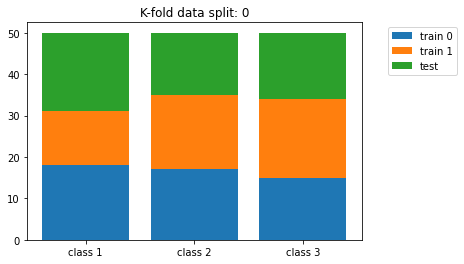

Train folds: [0 2]
Test fold:   1


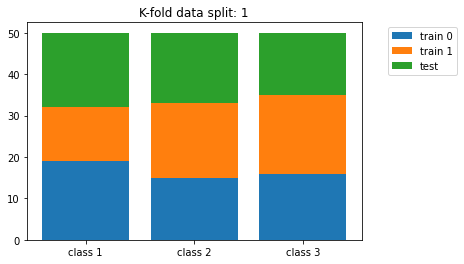

Train folds: [0 1]
Test fold:   2


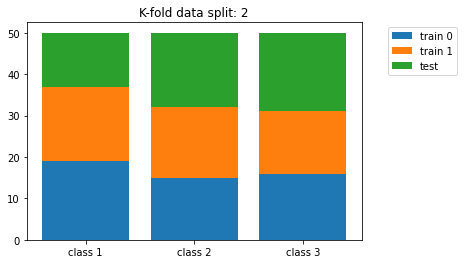

In [5]:
n_splits = 3
X_folds, y_folds = get_folds(data, target, n_splits)

for i in range(n_splits):
    # An array of the splits, i.e. [0, 1, 2]
    splits = range(n_splits)
    
    # Get all indices except the current one
    train_idx = np.setdiff1d(splits, [i])
    
    # Split the train and test sets by the folds
    # We use np.concatenate to make sure we get a single array out of the train folds put together
    X_train, X_test = np.concatenate(X_folds[train_idx]), X_folds[i]
    y_train, y_test = np.concatenate(y_folds[train_idx]), y_folds[i]
    
    # This is where you'd normally do training on the different folds
    print("Train folds:", train_idx)
    print("Test fold:  ", i)
    
    # Let's plot how the data is represented across folds
    # We np.split it to restore the folds for illustrative purposes
    plot_data_representation(y_train, y_test, n_splits)

## Using Sklearn

Of course, our function is a rudimentary version that requires some working around (but it's easier to follow, because we've written it ourselves.

Of course, sklearn has a method just for this - that also enables us to **stratify** the folds, which is much preferred for classificaion.

It's also made using the python generator pattern (don't worry if you don't know it), which allows us to iterate them directly, and not have to keep track of indices etc.

In [6]:
n_splits = 3
kfold = model_selection.StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

Train fold size: 100
Test fold size:  50


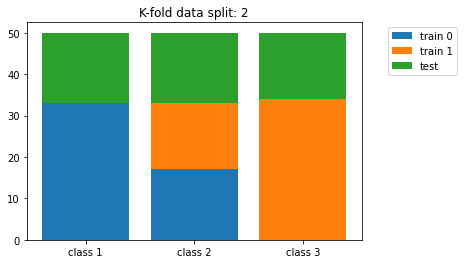

Train fold size: 100
Test fold size:  50


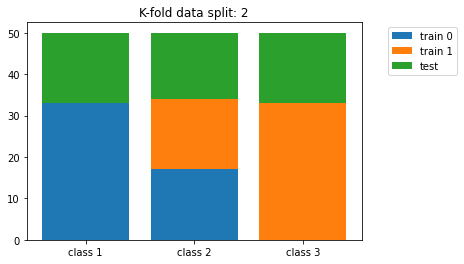

Train fold size: 100
Test fold size:  50


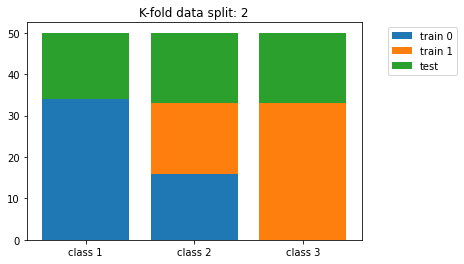

In [7]:
for train_idx, test_idx in kfold.split(data, target):
    # Split the train and test sets by the folds
    X_train, X_test = data[train_idx], data[test_idx]
    y_train, y_test = target[train_idx], target[test_idx]
    
    # This is where you'd normally do training on the different folds
    print("Train fold size:", len(train_idx))
    print("Test fold size: ", len(test_idx))
    
    # Let's plot how the data is represented across folds 
    # We're wrapping it in an array to keep it compatible with our function above.
    plot_data_representation(y_train, y_test, n_splits)

notice, that it doesn't give you the explicit folds, but just the indices you need from your dataset (which is what you need to work with), so the plots are slightly different from what we see in our case. The results are similar though, and now more balanced across the target variable.

This is also why our plotting of the splits is a bit more arbitrary, since sklearn actually orders the classes within the dataset - even when shuffling them.

Rest assured, the data we train on is represened in both the training and test set for each fold.

As for implementational details, looking at the resulting arrays, my best guess is that sklearn in essence takes the original dataset and then just subtracts the randomized test_indices from each class to build the randomized, stratified test fold.